## Projet P3 OC Data Scientist: Concevez une application au service de la santé publique

Lien vers les consignes du projet sur openclassrooms : https://openclassrooms.com/fr/projects/628/assignment

Lien vers la définition des variables : https://world.openfoodfacts.org/data/data-fields.txt

#### Idée d'application: calculer un nutri-rein à partir des composantes nutritionnelles prépondérantes (sodium, graisses, proteines fibres,...) pour un patient en insuffisance rénale. Le nutri-rein sera comparé aux valeurs du nutri-score de la base Open Food Facts pour évaluer sa qualité.

#### Contrairement au nutri-score, le nutri-rein sera calculé par rapport à l'apport en énergie et en nutriments journalier nécessaire à un patient en insuffisance rénale (données sur les apports énergétiques édictées par des néphrologues du CHU de Lyon), évaluant les apports nutritionnels et énergétiques des produits sur la base de 3 repas-type: petit déjeuner, repas du midi, repas du soir.

## 1. Mise en place environnement et import des librairies

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display

import seaborn as sns
import os

pd.options.mode.chained_assignment = None  # default='warn'

# Versions des librairies
print("Version librairie pandas: " + pd.__version__)
print("Version librairie numpy: " + np.__version__)
print("Version librairie matplotlib: " + matplotlib.__version__)
print("Version librairie seaborn: " + sns.__version__)

Version librairie pandas: 1.1.3
Version librairie numpy: 1.19.2
Version librairie matplotlib: 3.3.2
Version librairie seaborn: 0.11.0


In [2]:
#Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

In [3]:
print(os.listdir("./Input"))

['datafood_appli.csv', 'datafood_final.csv', 'en.openfoodfacts.org.products.csv']


## 2. Fonctions

In [4]:
# Fonction qui renvoie la proportion de NaN sur l'ensemble du dataset
def print_proportion_nan(df_in):
        print('Proportion de NaN : {} %, Taille du jeu de données : {}\n'
              .format(round(df_in.isna().sum().sum()/(df_in.shape[0]*df_in.shape[1]),4)*100,
                      df_in.shape))
        return None

In [5]:
# Fonction qui reduit le dataset aux produits uniquement vendus en France (métropole et DOM-TOM)
def select_pays_france(df_in, liste_territoire):
    df_out = df_in[df_in['countries'].str.contains(liste_territoire, na=False)]
    
    return df_out

In [6]:
# Fonction qui construit un dataframe indiquant le pourcentage de données disponibles par colonne du dataset datafood
def desc_data_dispo (df_in):
    df_desc_rempl=pd.DataFrame(index=['nbre valeurs manquantes', 'nbre de valeurs dispo.','taux remplissage'], columns=df_in.columns)
    for col in df_in.columns:
        nb_nan = df_in[col].isnull().sum()
        df_desc_rempl.loc['nbre valeurs manquantes',col] = nb_nan              
        df_desc_rempl.loc['nbre de valeurs dispo.', col]= df_in.shape[0]-nb_nan 
        df_desc_rempl.loc['taux remplissage', col]=round((df_in.shape[0]-nb_nan)/(df_in.shape[0]*1.0)*100,2)
        
    return df_desc_rempl

In [7]:
# Fonction qui affiche les données de la dataframe des donnés disponibles dans la dataset datafood, sous forme d'histogramme
def affich_taux_dispo (df_in, larg, haut):
    # Affichage des taux de remplissage par colonnes du datatest
    dict = {'variable' : df_in.columns,\
        'taux remplissage': df_in.loc['taux remplissage', df_in.columns],\
        'taux de Nan': 100 - df_in.loc['taux remplissage',df_in.columns]}

    df_grah_dispo = pd.DataFrame(dict)
    df_grah_dispo.reset_index(drop=True, inplace=True)
    df_grah_dispo = df_grah_dispo.sort_values(by='taux remplissage', ascending=False)

    barWidth=3
    plt.figure(figsize=(larg,haut))
    plt.gca().invert_yaxis()

    plt.barh(df_grah_dispo['variable'], df_grah_dispo['taux remplissage'], color='#a3acff')
    plt.barh(df_grah_dispo['variable'], df_grah_dispo['taux de Nan'], left=df_grah_dispo['taux remplissage'], color ='#b5ffb9')
    plt.title('Représentation du remplissage des données', fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylabel('variable', fontdict={'fontsize' : 10})
    plt.xlabel('Taux de remplissage en %', fontdict={'fontsize' : 10})

    plt.axvline(x=80, color='b')
    plt.text(82, -1, '>80%', color='b')
    plt.axvline(x=20, color='r')
    plt.text(12, -1, '<20%', color='r')
    plt.grid(True)
    plt.show()
    return None

In [8]:
# Fonction qui supprime les colonnes du dataset datafood avec moins de x % de valeurs disponibles
def del_col_taux_rempl (df_in, taux_rempli):
    print('Liste colonnes remplies à moins de ' + str(taux_rempli*100) + ' %')
    for col in df_in.columns:
          
        if df_in[col].count().sum(axis=0)/df_in.shape[0] < taux_rempli:
            print('colonne {} supprimée -------> seulement un taux de remplissage de {} %.'.format(col, round((df_in[col].count().sum(axis=0)/df_in.shape[0])*100,2)))
            df_in = df_in.drop(col, axis=1)

    return df_in

In [9]:
def del_col_hors_nutrim(df_in, liste_col_del):
    df_datafood_fr_autre = df_in.iloc[:, ~df_in.columns.str.contains('_100g')]
    for col in df_datafood_fr_autre.columns:
        if col in liste_col_del:
            print('------- Colonne ' + col + ' supprimée ----------')
            print('------- Liste des valeurs: --------')
            print('')
            print(df_datafood_fr_autre[col].unique())
            print('')
            df_in = df_in.drop(col, axis=1)
    return df_in    

In [10]:
# Fonction qui traite le valeurs NaN pour les colonnes numériques
# Méthode: suppression des lignes contenant des valeurs NaN pour chaque colonne
def traite_nan_num(df_in):
    print('------ Suppression des lignes contenant des valeurs NaN pour chaque variable quantitative du dataset datafood')
    val_num = ['int32', 'int64', 'float32', 'float64']
    df_datafood_num = df_in.select_dtypes(include=val_num)
   
    print('------ ' + 'Liste des colonnes:' + ' ------')
    print(df_datafood_num.columns)
   
    for col in df_datafood_num.columns:
        df_in = df_in.dropna(subset=[col], axis=0)
        print('Suppression NaN pour la colonne ' + col)
    
    print('------- Nombre de colonnes traitées: ' + str(len(df_datafood_num.columns)) + ' ------')
    print(' ')
    print('------ Dataset suite suppression des lignes avec des valeurs NaN sur les colonnes quantitatives ------')
    print_proportion_nan(df_in )
    return df_in

In [11]:
# Fonction qui traite le valeurs NaN pour les variables qualitatives
# Methode: imputation de la valeur 'unknown' dans le cas de valeurs NaN pour chaque colonne 
def traite_nan_obj(df_in, val_imput):
    print('------ Imputation de la valeur ''unknown'' dans le cas de valeurs NaN pour chaque variable qualitative du dataset datafood')
    val_obj = ['object']
    df_datafood_obj = df_in.select_dtypes(include=val_obj)
   
    print('------ ' + 'Liste des colonnes:' + ' ------')
    print(df_datafood_obj.columns)
   
    for col in df_datafood_obj.columns:
        df_in[col].fillna(val_imput, inplace=True)
        print('Imputation valeur '+ val_imput + ' pour remplacer NaN pour la colonne ' + col)
    
    print('------- Nombre de colonnes traitées: ' + str(len(df_datafood_obj.columns)) + ' ------')
    print(' ')
    print('------ Dataset suite imputation de la valeur ''unknown'' sur les colonnes qualitatives ayant des valeurs NaN ------')
    print_proportion_nan(df_in )
    return df_in

In [12]:
# Fonctions de traitement des NaN
def traite_nan(df_in, val_imput):
    df_datafood_nan_temp = traite_nan_num(df_in)
    df_datafood_final_nan = traite_nan_obj(df_datafood_nan_temp, val_imput)
    return df_datafood_final_nan

In [13]:
# Fonction qui affiche les outliers pour les variables quantitatives
def desc_outliers(df_in):
    val_num = ['int32', 'int64', 'float32', 'float64']
    df_num = df_in.select_dtypes(include=val_num)
    
    print(' ------ Traitement de outliers: liste des colonnes quantitatives à traiter ------')
    print(df_num.columns)
    
    # Création dataframe des récapitulatifs des outliers des nutriments et des scores
    list_index = []
    df_outlier_recap = pd.DataFrame(index=list_index, columns=['Min','Max','Nbre > 100g','Nbre < 0g','Nutriscore >= 0',\
                                                               'Nutriscore < 0','Sel > 8g','Sodium > 3g'])
    
    for col in df_num.columns:
        list_index.append(col)
        
        # Valeur min
        min = df_in[col].min()
        
        # Valeur max
        max =  df_in[col].max()
        
        if col != 'nutriscore_score' and col != 'nutrition-score-fr_100g':
            list_index.append(col)
        
            # Nbre de valeurs > 100 g
            nbre_sup_100g = df_in[df_in[col] > 100].count()[[col]]
            
            # Nbre de valeurs < 0 g
            nbre_inf_0g = df_in[df_in[col] < 0].count()[[col]]
            
            # Teneur de sel > 8 g
            if col == 'salt_100g':
                nbre_sel_sup_8g =  df_in[df_in[col] > 8].count()[[col]]
                df_outlier_recap.loc[col] = [min ,max, nbre_sup_100g.loc[col], nbre_inf_0g.loc[col], 'SO', 'SO',\
                                         nbre_sel_sup_8g.loc[col],0] 
            
            # Teneur de sodium > 3 g
            elif col == 'sodium_100g':
                nbre_sodium_sup_3g = df_in[df_in[col] > 3].count()[[col]]
                df_outlier_recap.loc[col] = [min ,max, nbre_sup_100g.loc[col], nbre_inf_0g.loc[col], 'SO', 'SO',\
                                         0,nbre_sodium_sup_3g.loc[col]]   
            
            else:
                df_outlier_recap.loc[col] = [min ,max, nbre_sup_100g.loc[col],nbre_inf_0g.loc[col],'SO','SO','SO','SO']
         
        else:
            
            # Nbre de valeurs Nutri-score >= 0
            nbre_sup_eg_0 = df_in[df_in[col] >= 0].count()[[col]]
            
            # Nbre de valeurs Nutri-score < 0
            nbre_inf_0 = df_in[df_in[col] < 0].count()[[col]]
            
            
            df_outlier_recap.loc[col] = [min ,max, 'SO', 'SO',nbre_sup_eg_0.loc[col],nbre_inf_0.loc[col],'SO','SO']    
           
    
    print('')
    print('------ Informations complémentaires sur les valeurs aberrantes ------')
    # Comptage des lignes dont  la somme des nutriments est supérieure à 100g
    df_num['somme_nutriments'] = df_num.apply(lambda row: row.fat_100g + row.carbohydrates_100g\
                                                                + row.fiber_100g + row.proteins_100g\
                                                                + row.sodium_100g, axis=1)
    df_num_sum = df_num[['somme_nutriments']]
    compte_sum_nut = df_num_sum[df_num_sum['somme_nutriments'] > 100].count()
    print('Nombre de lignes avec somme nutriments > 100 g: ' + str(compte_sum_nut))
    
    
    df_recap_outliers = df_outlier_recap
        
    return df_recap_outliers, df_num_sum

In [14]:
# Fonction qui supprime les outliers dans le dataset datafood
def drop_outliers(df_in):
    val_num = ['int32', 'int64', 'float32', 'float64']
    df_num = df_in.select_dtypes(include=val_num)
     
    for col in df_num.columns:
        # Pour l'apport énergétique en kcal, suppression produits avec appport énergétique > 900 kcal
        if col == 'energy-kcal_100g':
            df_in.drop(df_in[df_in['energy-kcal_100g'] > 900].index, inplace = True)
            print('------ Dataset suite suppression lignes avec ' + col + ' > 900 kcal')
            print_proportion_nan(df_in)
        
        # Pour l'apport énergétique en kj, suppression produits avec appport énergétique > 4 000 kj
        elif col == 'energy_100g':
            df_in.drop(df_in[df_in['energy_100g'] > 4000].index, inplace = True)
            print('------ Dataset suite suppression lignes avec ' + col + ' > 4000 kj')
            print_proportion_nan(df_in)
        
        # Les variables nutri-score ne sont pas concernées par le traitement
        elif col == 'nutriscore_score' or col == 'nutrition-score-fr_100g':
            print('------- Colonne ' + col + ' non concernée par le traitement des outliers --------' )
            
        else:    
            
            # Suppression des valeurs > 100 g
            df_in.drop(df_in[df_in[col] > 100].index, inplace = True)
            print('------ Dataset suite suppression lignes avec ' + col + ' > 100 g')
            print_proportion_nan(df_in)
            
            # Suppression des valeurs < 0 g
            df_in.drop(df_in[df_in[col] < 0].index, inplace = True)
            print('------ Dataset suite suppression lignes avec ' + col + ' < 0 g')
            print_proportion_nan(df_in)
            
            if col == 'salt_100g':
                df_in.drop(df_in[df_in[col] > 8].index, inplace = True)
                print('------ Dataset suite suppression lignes avec ' + col + ' > 8 g')
                print_proportion_nan(df_in)
                
            if col == 'sodium_100g':
                df_in.drop(df_in[df_in[col] > 3].index, inplace = True)
                print('------ Dataset suite suppression lignes avec ' + col + ' > 3 g')
                print_proportion_nan(df_in)
                
    return df_in

In [15]:
# Fonction complémentaire pour la suppression des valeurs aberrantes
def drop_outliers_compl(df_in):
    df_in.drop(df_in[df_in['somme_nutriments'] > 100].index, inplace = True)
    print('------ Dataset suite suppression somme nutriments > 100 g ------')
    print_proportion_nan(df_in)   
    
    return df_in

## 3. Chargement et description des données

In [16]:
df_datafood = pd.read_csv('./input/en.openfoodfacts.org.products.csv', delimiter='\t', encoding='utf-8', low_memory=False)

In [17]:
df_datafood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786430 entries, 0 to 1786429
Columns: 186 entries, code to carnitine_100g
dtypes: float64(123), int64(2), object(61)
memory usage: 2.5+ GB


#### Le dataset df_datafood contient 1 786 430 produits et 186 variables.

In [18]:
df_datafood.head(3)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,-soluble-fiber_100g,-insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000000000017/vitoria-crackers,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,"en:to-be-completed, en:nutrition-facts-completed, en:ingredients-to-be-completed, en:expiration-date-to-be-completed, en:packaging-code-to-be-completed, en:characteristics-to-be-completed, en:categories-to-be-completed, en:brands-to-be-completed, en:packaging-to-be-completed, en:quantity-to-be-completed, en:product-name-completed, en:photos-to-be-validated, en:photos-uploaded","en:to-be-completed,en:nutrition-facts-completed,en:ingredients-to-be-completed,en:

#### Le dataset contient des données catégorielles:
- nom du produit
- catégories sous formes de tags (catégorie principale /secondaire à laquelle appartient le produit,....)
- marque du produit, point de vente,...
- ingrédients du produit
- ...

#### et des données quantitatives:
- composition nutritionnelle du produit (sodium, protéines, lipides pour 100 g de produit,....)
- nombre d'additifs
- nombre d'allergènes
- ...

#### mais aussi des méta-données comme la date d'entrée du produit dans la base, date de mise à jour,...

In [19]:
df_datafood.describe()

,created_t,last_modified_t,cities,allergens_en,serving_quantity,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutriscore_score,nova_group,ecoscore_score_fr,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,-soluble-fiber_100g,-insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
count,1.786430e+06,1.786430e+06,0.0,0.0,4.672340e+05,0.0,691140.000000,691140.000000,0.0,691140.000000,0.0,665470.000000,604189.000000,431858.000000,1.288610e+05,1.365258e+06,1.418636e+06,976.000000,1.410525e+06,1.367181e+06,19.000000,4.000000,4.000000,11.000000,16.000000,9.000000,2.000000e+01,7.000000,82.000000,31.000000,6.000000e+00,9.000000,16.000000,11.000000,47452.000000,47448.000000,1993.000000,486.000000,118.000000,172.000000,517.000000,238.000000,75.000000,10.000000,6.000000,91.000000,60.000000,2.000000,20.000000,10.000000,5.000000e+00,1.100000e+01,264592.000000,268374.000000,1.410068e+06,1.393007e+06,142.000000,80.000000,80.000000,777.000000,40.000000,102.000000,500.000000,3581.000000,470158.000000,3609.000000,3339.000000,1.411559e+06,43.000000,51.000000,26.000000,1.358282e+06,1.358278e+06,2.008000e+04,212198.000000,82.000000,9559.000000,3353.000000,1120.000000,219821.000000,23428.000000,22520.000000,23600.000000,15848.000000,10119.000000,8450.000000,1.260100e+04,1055.000000,6013.000000,121.000000,377.000000,91879.000000,689.000000,269799.000000,13685.000000,264501.000000,14603.000000,10113.000000,4254.000000,4017.000000,322.000000,2456.000000,196.000000,287.000000,2117.000000,434.000000,163.000000,188.000000,8799.000000,364.000000,11746.000000,310.000000,5928.000000,5.000000,460.000000,11659.000000,665475.000000,9.000000,4.000000,1.0,43.000000,1712.000000,32.000000,46.000000,20.000000
mean,1.552434e+09,1.587653e+09,NaN,NaN,2.378070e+16,NaN,2.043020,0.020547,NaN,0.068979,NaN,9.168840,3.430789,48.380880,5.172674e+37,6.433136e+06,4.698569e+36,360.911988,1.458315e+01,1.247652e+01,0.182769,12.097506,32.352225,95.487091,20.183994,33.395676,1.273718e+02,61.471143,10.202736,1.529485,4.470403e+01,2.447952,34.451488,0.258281,9.929

#### Au premier coup d'oeil, il apparaît qu'il y a beaucoup de valeurs manquantes et des outliers dans les variables des composantes nutritionnelles des différents produits.

In [20]:
df_datafood.dtypes

code                                           object
url                                            object
creator                                        object
created_t                                       int64
created_datetime                               object
last_modified_t                                 int64
last_modified_datetime                         object
product_name                                   object
abbreviated_product_name                       object
generic_name                                   object
quantity                                       object
packaging                                      object
packaging_tags                                 object
packaging_text                                 object
brands                                         object
brands_tags                                    object
categories                                     object
categories_tags                                object
categories_en               

#### On se rend compte que certaines composantes nutritionnelles sont décomposées en sous-composantes.
#### Exemples:
- graisses saturées (satured-fat_100g) et ses différents composants
- décomposition des composants de l'oméga 3, 6 et 9
- sucres, ...


### Nombre de produits dans le dataset

In [21]:
df_datafood['product_name'].nunique()

1121968

#### Il y a 1121968 produits dans le dataset, il y a quelques valeurs manquantes pour les produits.

## 4. Constitution de jeu de données et nettoyage

### 4.1 Constitution du jeu de données

In [22]:
# Sauvegarde du dataset d'origine
# On travaille à présent sur df_datafoood
df_datafood_orig = df_datafood.copy()

#### Suppression des doublons potentiels

In [23]:
# Suppression des doublons potentiels
df_datafood = df_datafood.drop_duplicates()
print(df_datafood.shape)

(1786428, 186)


##### 2 lignes supprimées

#### Nombre de produits vendus sur le sol français

In [24]:
# Affichage de la liste des pays
df_datafood.countries.unique().tolist()

['France',
 'en:es',
 'en:France',
 'en:france',
 'en:fr',
 'United States',
 'Irlande',
 'en:FR',
 nan,
 'en:be',
 'United Kingdom',
 'États-Unis, en:france',
 'France, United States',
 'France,États-Unis',
 'Spain',
 'en:Ivory Coast',
 'Canada',
 'España',
 'Suisse',
 'en:it',
 'Germany',
 'France,Belgique',
 'Belgium',
 'France, États-Unis',
 'Pérou',
 'en:germany',
 'Schweiz',
 'Oman',
 'Deutschland',
 'Slovenia',
 'en:DE',
 'en:de',
 'Frankreich, Deutschland',
 'France,Germany,Netherlands',
 'en:KW',
 'ફ્રાન્સ',
 'en:spain',
 'France,Switzerland',
 'Frankreich, en:de',
 'France, en:de',
 'Italy',
 'Romania',
 'en:US',
 'Australia',
 'en:Norway',
 'en:lu',
 'en:Spain',
 'en:United Arab Emirates',
 'en:Italy',
 'en:us',
 'Portugal',
 'en:Dominican Republic',
 'en:RE',
 'Espagne',
 'en:Canada',
 'United Kingdom,en:united-kingdom',
 'Israel',
 'en:CH',
 'en:Netherlands',
 'us',
 'Royaume-Uni',
 'Belgique,France',
 'en:United States',
 'en:ca',
 'en:Saudi Arabia',
 'en:pl',
 'en:gb',
 

In [25]:
liste_loc_france= "France|france|en:fr|en:FR|Frankreich|Francia|Réunion|La Réunion|Français|French Polynesia"\
                  "|Polynésie française|França|Martinique|New Caledonia|Nouvelle-Calédonie|Guadeloupe|Saint Martin"\
                  "|Guyana|Saint Pierre and Miquelon|Saint-Pierre-et-Miquelon"

df_datafood_fr = select_pays_france(df_datafood, liste_loc_france)
print_proportion_nan(df_datafood_fr)
print("Seuls les produits vendus sur le sol français sont séléctionnés et leur nombre est de : {}, soit {:.2f} % des données".format(len(df_datafood_fr), len(df_datafood_fr)/len(df_datafood)*100))

Proportion de NaN : 79.77 %, Taille du jeu de données : (801262, 186)

Seuls les produits vendus sur le sol français sont séléctionnés et leur nombre est de : 801262, soit 44.85 % des données


#### Représentation du ratio de données disponibles par colonne du dataset datafood

In [26]:
# Appel de la fonction pour construire la dataframe récapitulant les donneées disponibles par colonne du dataset datafood
df_datafood_fr_dispo = desc_data_dispo(df_datafood_fr)
df_datafood_fr_dispo

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,-soluble-fiber_100g,-insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
nbre valeurs manquantes,0,0,1,0,0,0,0,23071,797609,725450,540085,625202,625212,798733,377424,377460,435472,435473,435473,752231,752297,752297,730940,730979,553354,553330,553330,713690,713709,732618,801262,727374,705932,652680,0,0,0,557771,714069,801262,740136,723842,723842,717108,722509,801262,557770,801260,672390,672390,557770,801262,789567,557770,801262,779279,517869,517869,596753,11179,48,0,0,0,797108,540261,540261,435473,435473,77486,77486,306951,306951,403868,403868,729152,203360,176071,801132,182003,178844,801258,801259,801260,801259,801256,801261,801258,801260,801231,801249,801261,801261,801260,801258,798164,798143,799924,800919,801200,801162,800972,801059,801230,801258,801262,801213,801240,801262,801259,801261,801260,801260,797633,797609,182084,179573,801238,801233,801210,801034,801248,801198,800975,800497,662203,801074,801081,180139,801223,801231,801246

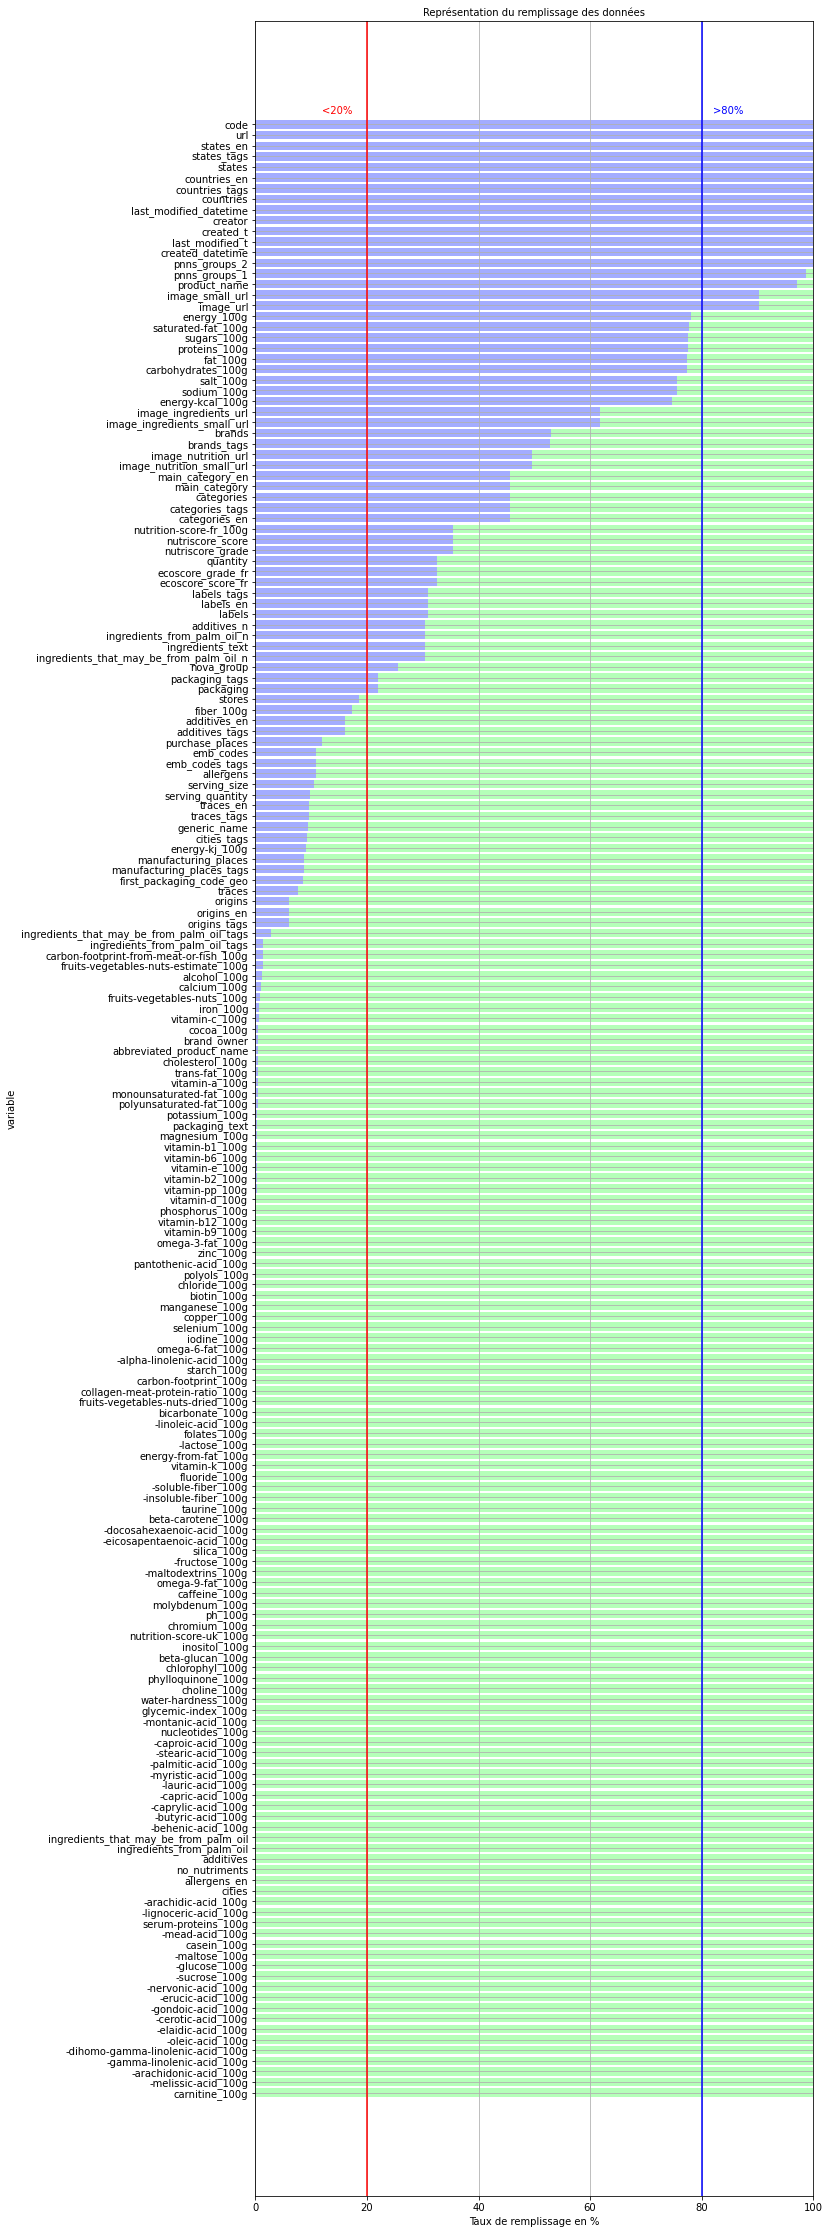

In [27]:
# Appel de la fonction pour l'affichage de l'histogramme des données disponibles  par colonne dans la dataset datafood
affich_taux_dispo(df_datafood_fr_dispo,10,40)

##### On voit que beaucoup de nutriments (colonnes qui se terminent par _100g) ne sont pas ou peu renseignés (moins de 2% de données disponibles), moins d'une dizaine de nutriments est exploitable avec environ 70 - 75 % de données disponibles (graisses, graisses saturées, protéines, glucides,...).

#### Focus sur les nutriments (colonnes se terminant par _100g)

In [28]:
# Appel de la fonction pour construire la dataframe récapitulant les donneées disponibles par nutriment du dataset datafood
df_datafood_fr_100g = df_datafood_fr.filter(like='_100g', axis=1)
df_data_dispo_fr_100g = desc_data_dispo(df_datafood_fr_100g)
df_data_dispo_fr_100g

,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,-soluble-fiber_100g,-insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
nbre valeurs manquantes,729152,203360,176071,801132,182003,178844,801258,801259,801260,801259,801256,801261,801258,801260,801231,801249,801261,801261,801260,801258,798164,798143,799924,800919,801200,801162,800972,801059,801230,801258,801262,801213,801240,801262,801259,801261,801260,801260,797633,797609,182084,179573,801238,801233,801210,801034,801248,801198,800975,800497,662203,801074,801081,180139,801223,801231,801246,195618,195619,791822,797879,801213,799657,799486,801080,796442,799079,799471,799489,799302,799805,801024,799671,800859,800337,801184,801033,798597,800855,792900,799653,795986,798821,800335,800886,800866,801076,800976,801212,801215,800915,801154,801208,801144,794970,800942,790800,800965,796842,801259,800944,789631,517866,801257,801258,801262,801231,801233,801245,801238,801248
nbre de valeurs dispo.,72110,597902,625191,130,619259,622418,4,3,2,3,6,1,4,2,31,13,1,1,2,4,3098,3119,1338,343,62,100,290,203,32,4,0,49,22,0,3,1,2,2,3629,3653,619178,621689,24,29,52,228,14,64,287,765,139059,188,181,621123,39,31,16,605644,605643,9440,3383,49,1605,1776,182,4820,2183,1791,1773,1960,1457,238,1591,403,925,78,229,2665,407,8362,1609,5276,2441,927,376,396,186,286,50,47,347,108,54,118,6292,320,10462,297,4420,3,318,11631,283396,5,4,0,31,29,17,24,14
taux remplissage,9,74.62,78.03,0.02,77.29,77.68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.39,0.39,0.17,0.04,0.01,0.01,0.04,0.03,0,0,0,0.01,0,0,0,0,0,0,0.45,0.46,77.28,77.59,0,0,0.01,0.03,0,0.01,0.04,0.1,17.35,0.02,0.02,77.52,0,0,0,75.59,75.59,1.18,0.42,0.01,0.2,0.22,0.02,0.6,0.27,0.22,0.22,0.24,0.18,0.03,0.2,0.05,0.12,0.01,0.03,0.33,0.05,1.04,0.2,0.66,0.3,0.12,0.05,0.05,0.02,0.04,0.01,0.01,0.04,0.01,0.01,0.01,0.79,0.04,1.31,0.04,0.55,0,0.04,1.45,35.37,0,0,0,0,0,0,0,0


##### Pour information, il faut limiter les apports nutritionnels sur les nutriments suivants, dans le cas de patients atteints d'insuffisance rénale:
 - sodium
 - sucres
 - glucides
 - protéines
 - potassium
 - phosphore
 - calcium
 - fibres
 - graisses (dont graisses saturées)

##### De plus, il faut limiter les apports en énergie (kilo-joules ou kilo-calories).

##### On se rend compte que certaines variables décrites ci-dessus sont bien représentées:
 - apport énérgétique (energy-kcal_100g ou energy_100g) avec un taux de données disponibles respectivement de 74 % et 78 %
 - graisses (fat_100g) et graisses saturées (saturated-fat_100g) avec un taux de données disponibles de 77 %
 - glucides (carbohydrates_100g) et sucres (sugars_100g) avec un taux de données disponibles de 77 %
 - proteines (proteins_100g) avec un taux de données disponibles de 77 %
 - sodium (sodium_100g) avec un taux de données disponibles de 75 %

##### Par contre, des nutriments intéressants pour notre application sont peu représentés:
 - graisses non saturées (monounsaturated-fat_100g et polyunsaturated-fat_100g) avec un taux de données disponibles de 0,39 %
 - les fibres (fibers_100g) avec un taux de données disponibles de 17 %
 - potassium (potassium_100g) avec un taux de données disponibles de 0,33 %
 - phosphore (phosphorus_100g) avec un taux de données disponibles de 0,2 %
 - calcium (calcium_100g) avec un taux de données disponibles de 1 %


#### Suppression des colonnes de nutriments avec moins de 10% de données disponibles
L'idée est d'essayer de garder les données de la variable 'fibers_100g' et les variables avec plus de 70 % de données disponibles, et d'éliminer les variables avec très peu de données disponibles (moins de 10 %).

In [29]:
# Appel fonction pour suppression des colonnes du dataset datafood avec moins de 10% de données disponibles
df_datafood_fr_100g_corr= del_col_taux_rempl (df_datafood_fr, 0.1)
print_proportion_nan(df_datafood_fr_100g_corr)

Liste colonnes remplies à moins de 10.0 %
colonne abbreviated_product_name supprimée -------> seulement un taux de remplissage de 0.46 %.
colonne generic_name supprimée -------> seulement un taux de remplissage de 9.46 %.
colonne packaging_text supprimée -------> seulement un taux de remplissage de 0.32 %.
colonne origins supprimée -------> seulement un taux de remplissage de 6.12 %.
colonne origins_tags supprimée -------> seulement un taux de remplissage de 6.11 %.
colonne origins_en supprimée -------> seulement un taux de remplissage de 6.11 %.
colonne manufacturing_places supprimée -------> seulement un taux de remplissage de 8.78 %.
colonne manufacturing_places_tags supprimée -------> seulement un taux de remplissage de 8.77 %.
colonne first_packaging_code_geo supprimée -------> seulement un taux de remplissage de 8.57 %.
colonne cities supprimée -------> seulement un taux de remplissage de 0.0 %.
colonne cities_tags supprimée -------> seulement un taux de remplissage de 9.22 %.
co

colonne calcium_100g supprimée -------> seulement un taux de remplissage de 1.04 %.
colonne phosphorus_100g supprimée -------> seulement un taux de remplissage de 0.2 %.
colonne iron_100g supprimée -------> seulement un taux de remplissage de 0.66 %.
colonne magnesium_100g supprimée -------> seulement un taux de remplissage de 0.3 %.
colonne zinc_100g supprimée -------> seulement un taux de remplissage de 0.12 %.
colonne copper_100g supprimée -------> seulement un taux de remplissage de 0.05 %.
colonne manganese_100g supprimée -------> seulement un taux de remplissage de 0.05 %.
colonne fluoride_100g supprimée -------> seulement un taux de remplissage de 0.02 %.
colonne selenium_100g supprimée -------> seulement un taux de remplissage de 0.04 %.
colonne chromium_100g supprimée -------> seulement un taux de remplissage de 0.01 %.
colonne molybdenum_100g supprimée -------> seulement un taux de remplissage de 0.01 %.
colonne iodine_100g supprimée -------> seulement un taux de remplissage 

#### Représentation du ratio des données disponibles sur la dataset corrigé

In [30]:
df_datafood_fr_corr_dispo = desc_data_dispo(df_datafood_fr_100g_corr)
df_datafood_fr_corr_dispo

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,serving_size,additives_n,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,ecoscore_score_fr,ecoscore_grade_fr,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
nbre valeurs manquantes,0,0,1,0,0,0,0,23071,540085,625202,625212,377424,377460,435472,435473,435473,553354,553330,553330,713690,713709,705932,652680,0,0,0,557771,714069,717108,557770,672390,672390,557770,557770,517869,517869,596753,11179,48,0,0,0,540261,540261,435473,435473,77486,77486,306951,306951,403868,403868,203360,176071,182003,178844,182084,179573,662203,180139,195618,195619,517866
nbre de valeurs dispo.,801262,801262,801261,801262,801262,801262,801262,778191,261177,176060,176050,423838,423802,365790,365789,365789,247908,247932,247932,87572,87553,95330,148582,801262,801262,801262,243491,87193,84154,243492,128872,128872,243492,243492,283393,283393,204509,790083,801214,801262,801262,801262,261001,261001,365789,365789,723776,723776,494311,494311,397394,397394,597902,625191,619259,622418,619178,621689,139059,621123,605644,605643,283396
taux remplissage,100,100,100,100,100,100,100,97.12,32.6,21.97,21.97,52.9,52.89,45.65,45.65,45.65,30.94,30.94,30.94,10.93,10.93,11.9,18.54,100,100,100,30.39,10.88,10.5,30.39,16.08,16.08,30.39,30.39,35.37,35.37,25.52,98.6,99.99,100,100,100,32.57,32.57,45.65,45.65,90.33,90.33,61.69,61.69,49.6,49.6,74.62,78.03,77.29,77.68,77.28,77.59,17.35,77.52,75.59,75.59,35.37


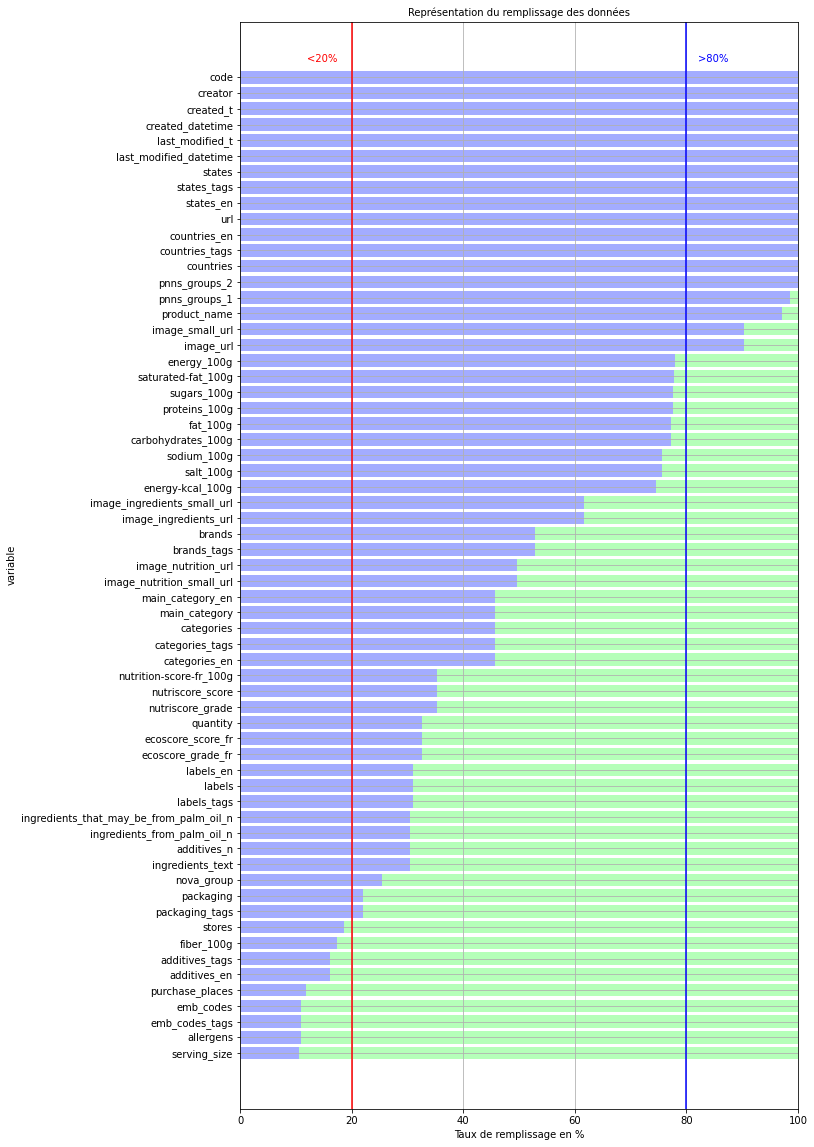

In [31]:
# Appel de la fonction pour l'affichage de l'histogramme des données disponibles  par colonne dans la dataset datafood corrigé
affich_taux_dispo(df_datafood_fr_corr_dispo,10,20)

#### Suppression des colonnes du dataset hors nutriments car inutiles pour l'application
   - colonnes pour les méta-données (colonnes creator,created_t, created_datetime, last_modified_datetime, last_modified_t).
   
   => *ces données n'apportent pas d'information pertinente pour l'application.*
   
   
   - colonnes sur l'emballage (colonnes packaging, packaging_tags).
   
   => *l'emballage n'indique rien sur la qualité nutritionelle du produit.*
   
   
   - colonnes pour les liens hypertextes et les images (colonnes url, image_url, image_small_url, image_ingredients_url, image_ingredients_small_url, image_nutrition_url, image_nutrition_small_url).
   
   => *les images des produits et la fiche descriptive du produit ne sont pas indispensables pour calculer le nutri-rein.*
   
   
   - colonnes sur l'état de l'observation (states, states_tags, states_en).
   
   => *le statut de l'observation du produit (en cours, complet,...) peut apporter une information sur la qualité de l'information, mais n'est pas indispensable pour calculer le nutri-rein.*
   
   
   - colonnes sur le regroupement des produits (colonnes categories_tags, catégories_en, pnns_groups_1, main_category_en).
   
   => *seules les variables categories et pnns_groups_2 sont conservées pour décrire les regroupement des produit (viandes, poissons,...). Les autres variables sont supprimées car elles sont moins représentatives pour regrouper les produits.*
   
   
   - colonnes sur les pays (colonnes countries_tags, countries_en).
   
   => *seule la variable countries (seulement les pays vendus en France) est conservée. Les autres variables sont supprimées car elles sont redondantes.*
   
   
   - colonnes sur les marques (colonnes brands_tags, brands).
   
   => *le nutri-rein est indépendant des marques.*
   
   
   - colonnes sur les labels (colonnes labels_tags, labels_en).
   
   => *les labels n'apportent aucune information significative pour le calcul du nutri-rein.*
   
   
   - colonnes sur les codes d'emballage (colonne emb_code, emb_codes_tags).
   
   => *les codes d'emballage ne déterminent pas le calcul du nutri-rein.*
   
   
   - colonnes sur le lieux d'achat et les magasins (colonnes purchase_places, stores).
   
   => *le nutri-rein est indépendant des lieux d'achat.*
   
   
   - colonnes sur les allergènes et additifs, présence huile de palme (colonne allergens, additives_n, additives_tags, additives_en, ingredients_from_palm_oil_n, ingredients_that_may_be_from_palm_oil_n).
   
   => *même si les additifs, allergènes et la présence d'huile de palme sont néfastes pour la santé, ils ne sont pas spécifiquement mauvais pour les patients atteints d'insuffisance rénale.*
   
 
   - colonne sur les portions/quantités (colonne serving_size).
   
   => *la portion/masse totale de produit n'est pas primordiale, mais plutôt la quantité du produit ingérée par l'individu.*
   
   
   - colonnes sur scores autre que nutri-score (colonne nova_group, ecoscore_score_fr, ecoscore_grade_fr).
   
   => *l'application s'intéresse uniquement au nutri-score.*

In [32]:
# Appel fonction pour la suppression des colonnes (hors nutriment) non significatives pour la calcul du nutri-rein
liste_col_del = ['url','creator','created_t','created_datetime','last_modified_t', 'last_modified_datetime',\
                'packaging','packaging_tags','brands_tags','categories_tags','categories_en', 'labels_tags', 'labels_en',\
                'emb_codes','emb_codes_tags','purchase_places','stores','countries_tags', 'countries_en', 'allergens',\
                'additives_n', 'additives_tags','additives_en','serving_size','ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_n',\
                'nova_group', 'pnns_groups_1','states','states_tags','states_en','ecoscore_score_fr','ecoscore_grade_fr',\
                'main_category_en','image_url','image_small_url','image_ingredients_url','image_ingredients_small_url',\
                'image_nutrition_url', 'image_nutrition_small_url']
df_nutri_rein = del_col_hors_nutrim(df_datafood_fr_100g_corr, liste_col_del)
print_proportion_nan(df_nutri_rein)

------- Colonne url supprimée ----------
------- Liste des valeurs: --------

['http://world-en.openfoodfacts.org/product/0000000000017/vitoria-crackers'
 'http://world-en.openfoodfacts.org/product/0000000000031/cacao'
 'http://world-en.openfoodfacts.org/product/0000000000100/moutarde-au-mout-de-raisin-courte-paille'
 ...
 'http://world-en.openfoodfacts.org/product/999999999/the-noir-bio-darjeeling-pages'
 'http://world-en.openfoodfacts.org/product/9999999999994/light-free-skyr-a-boire'
 'http://world-en.openfoodfacts.org/product/999999999999999/signal-toothpaste']

------- Colonne creator supprimée ----------
------- Liste des valeurs: --------

['kiliweb' 'isagoofy' 'del51' ... 'serayet' 'malard' 'lion76']

------- Colonne created_t supprimée ----------
------- Liste des valeurs: --------

[1529059080 1539464774 1444572561 ... 1608105503 1613129728 1587222660]

------- Colonne created_datetime supprimée ----------
------- Liste des valeurs: --------

['2018-06-15T10:38:00Z' '2018-10-

------- Colonne allergens supprimée ----------
------- Liste des valeurs: --------

[nan 'en:mustard' 'en:eggs,en:mustard' ...
 'fr:Gs1:T4078:AI,fr:Gs1:T4078:BA,fr:Gs1:T4078:BB,fr:Gs1:T4078:BO,fr:Gs1:T4078:BP,fr:Gs1:T4078:BS,fr:Gs1:T4078:CN,fr:Gs1:T4078:CT,fr:Gs1:T4078:GE'
 'fr:Gs1:T4078:AI,fr:Gs1:T4078:BA,fr:Gs1:T4078:BN,fr:Gs1:T4078:BP,fr:Gs1:T4078:CN,fr:Gs1:T4078:CO,fr:Gs1:T4078:EG,fr:Gs1:T4078:GE,fr:Gs1:T4078:HX'
 'en:eggs,en:gluten,en:milk,en:nuts,en:peanuts,fr:biscuit spéculoos']

------- Colonne serving_size supprimée ----------
------- Liste des valeurs: --------

[nan 'serving' '16 ml' ... '5 cm' '214' '15,5g']

------- Colonne additives_n supprimée ----------
------- Liste des valeurs: --------

[nan  0.  5.  1.  2.  3.  4. 10.  7.  8.  6. 11.  9. 12. 17. 13. 15. 16.
 14. 20. 19. 18. 22. 23. 30. 25. 21. 28. 26. 24.]

------- Colonne additives_tags supprimée ----------
------- Liste des valeurs: --------

[nan 'en:e150,en:e160a,en:e202,en:e316,en:e466' 'en:e406' ...
 'en:e1200

------- Colonne ecoscore_score_fr supprimée ----------
------- Liste des valeurs: --------

[ nan  60.  83.  81.  29.  34.  79.  80.   9.  39.  67.  55.  82.  32.
  53.  72.  41.  64.  74.  99.  50.  28.  92.  10.  35.  73.  62.  94.
  76.  11.  66.  23.  33.  36.  42.   1.  43.  26.  63.  24.  25.  51.
  22.  54.  20.  68.  37.  13.  91. 119.  21.  85.  89.  40.  19.  98.
  18.   0.  77. -12.  31.  52.  75.  49.  65. 103.  97.  45.  84.  88.
  -1.  69.  -4.   7.   8.  27.  -7. -11.  17.  44.   6.  90.  71.  47.
 112.  57.  58.  56.  59.  15.  95.  30. 106.  48.  -2.  12.  38.  -8.
  61.  46. 101.  70. 109.   2.  78.  86.  14.  16.  -3.  87.  -5.  96.
 100. 107. 104. 105. -14.   4.  93.   5.  -6.   3. 114. 108. 102. 122.
 115. 110. 121. 120. 123. 111. 113. 116. 118. 117.  -9. -10. 124. -13.
 -23. 125. -17.]

------- Colonne ecoscore_grade_fr supprimée ----------
------- Liste des valeurs: --------

[nan 'b' 'd' 'e' 'c' 'a']

------- Colonne main_category_en supprimée ----------
-------

In [33]:
# Liste des colonnes du dataset pour le calcul du nutri-rein
df_nutri_rein.columns

Index(['code', 'product_name', 'quantity', 'brands', 'categories', 'labels',
       'countries', 'ingredients_text', 'nutriscore_score', 'nutriscore_grade',
       'pnns_groups_2', 'main_category', 'energy-kcal_100g', 'energy_100g',
       'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
       'nutrition-score-fr_100g'],
      dtype='object')

#### Suppression des lignes ne contenant pas de noms de produit renseigné

In [34]:
df_nutri_rein_product_rens = df_nutri_rein[df_nutri_rein["product_name"].isna() == False]
print_proportion_nan(df_nutri_rein_product_rens)

Proportion de NaN : 35.69 %, Taille du jeu de données : (778191, 23)



### 4.2 Nettoyage des données

#### 4.2.1 Traitement des valeurs NaN

##### Tout d'abord, on supprime les lignes pour chaque variable quantitative ayant des valeurs NaN.
##### Ensuite, on impute la valeur 'unknown' pour  chaque variable qualitative ayant des valeurs NaN.

In [35]:
# Appel de la fonction de traitement des NaN
df_nutri_rein_nan = traite_nan(df_nutri_rein_product_rens, 'unknown')

------ Suppression des lignes contenant des valeurs NaN pour chaque variable quantitative du dataset datafood
------ Liste des colonnes: ------
Index(['nutriscore_score', 'energy-kcal_100g', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g'],
      dtype='object')
Suppression NaN pour la colonne nutriscore_score
Suppression NaN pour la colonne energy-kcal_100g
Suppression NaN pour la colonne energy_100g
Suppression NaN pour la colonne fat_100g
Suppression NaN pour la colonne saturated-fat_100g
Suppression NaN pour la colonne carbohydrates_100g
Suppression NaN pour la colonne sugars_100g
Suppression NaN pour la colonne fiber_100g
Suppression NaN pour la colonne proteins_100g
Suppression NaN pour la colonne salt_100g
Suppression NaN pour la colonne sodium_100g
Suppression NaN pour la colonne nutrition-score-fr_100g
------- Nombre de colonnes traitées: 12 

#### 4.2.2 Traitement des outliers

In [36]:
# Liste des colonnes à traiter
df_nutri_rein_nan.columns

Index(['code', 'product_name', 'quantity', 'brands', 'categories', 'labels',
       'countries', 'ingredients_text', 'nutriscore_score', 'nutriscore_grade',
       'pnns_groups_2', 'main_category', 'energy-kcal_100g', 'energy_100g',
       'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
       'nutrition-score-fr_100g'],
      dtype='object')

##### Affichage d'une dataframe récapitulant les valeurs aberrantes potentielles
- valeur minimale et valeur maximale pour toutes les variables quantitatives (nutriments et nutri-score)
- nombre de nutriments dont la valeur est > à 100 g
- nombre de nutriments dont la valeur est > à 0 g
- nombre de valeurs positives pour le nutri-score
- nombre de valeurs négatives pour le nutri-score
- nombre de produits dont la teneur en sel est > à 8 g
- nombre de produits dont la teneur en sodium est > 3 g


In [37]:
# Appel de la fonction construisant la dataframe récapitulant les valeurs aberrantes par colonne
df_nutri_rein_outliers, df_nutri_sum = desc_outliers(df_nutri_rein_nan)
df_nutri_rein_outliers

 ------ Traitement de outliers: liste des colonnes quantitatives à traiter ------
Index(['nutriscore_score', 'energy-kcal_100g', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g'],
      dtype='object')

------ Informations complémentaires sur les valeurs aberrantes ------
Nombre de lignes avec somme nutriments > 100 g: somme_nutriments    1855
dtype: int64


,Min,Max,Nbre > 100g,Nbre < 0g,Nutriscore >= 0,Nutriscore < 0,Sel > 8g,Sodium > 3g
nutriscore_score,-15.0,40.0,SO,SO,67680,20204,SO,SO
energy-kcal_100g,0.0,208279.0,66811,0,SO,SO,SO,SO
energy_100g,0.0,86200.0,83887,0,SO,SO,SO,SO
fat_100g,0.0,110.0,1,0,SO,SO,SO,SO
saturated-fat_100g,0.0,400.0,2,0,SO,SO,SO,SO
carbohydrates_100g,0.0,1045.0,8,0,SO,SO,SO,SO
sugars_100g,0.0,101.0,1,0,SO,SO,SO,SO
fiber_100g,0.0,100.0,0,0,SO,SO,SO,SO
proteins_100g,0.0,110.0,1,0,SO,SO,SO,SO
salt_100g,0.0,2500.0,3,0,SO,SO,619,0


##### Analyse de la dataframe ci-dessus:
- les variables 'nutriscore_score' et 'nutriscore-score_100g' semblent représenter la même observation (nutri-score) et ne présentent pas de valeurs aberrantes sur le min et max (valeur min possible = -15 et valeurs max possible = + 40).


- les variables 'energy-kcal_100g' (apport énergétique en kcalories) et 'energy_100g' (apport énergétique en kjoules) présentent des valeurs aberrantes pour leurs valeurs maximales. Ainsi, il n'est pas possible d'avoir un apport énergétique en kcal de plus de 208 000 kcal (l'apport moyen pour un adulte-type est de l'ordre de 2 000 kcal). Par ailleurs, il n'est pas possible d'avoir un apport énergétique en kj de plus de 86 000 kj (l'apport moyen pour un adulte-type est de l'ordre de 8 400 kj).

=> *on supprimera les lignes du dataset dont la valeur de la variable 'energy-kcal_100g' est > à 900 kcal, mais aussi les lignes dont dont la valeur de la variable 'energy_100g' est > à 4 000 kj.*

- 7 nutriments (graisses, graisses saturées, glucides, sucres, protéines, sel, sodium) ont des valeurs maximales supérieures à 100 g

=> *on supprimera les lignes du dataset dont la valeur de ces nutriments est > à 100 g.*

- les produits dont la teneur en sel (variable 'salt_100g') dépassent 8 g doivent être écartés, car on considère que des valeurs de sel supérieures à 8 g par jour sont fortement préjudiciables pour la santé  d'un adulte-type.


- les produits dont la teneur en sodium (variable 'sodium_100g') dépassent 3 g doivent être écartés, car on considère que des valeurs de sodium supérieures à 3 g par jour sont fortement préjudiciables pour la santé d'un adulte-type.


- les produits dont la teneur en graisses saturées (variable 'saturated-fat_100g') dépasse la teneur en graisses, tous types de graisses confondus (variable 'fat_100g') doivent être écartés

=> *on supprimera les lignes dont la somme des nutriments est supérieure à 100 g.*

In [38]:
# Ajout colonne 'somme nutriments' au dataset datafood
frames = (df_nutri_rein_nan, df_nutri_sum)
df_nutri_rein_nan = pd.concat(frames,axis=1)

In [39]:
# Appel fonction pour la suppression des valeurs aberrantes
df_nutri_rein_net = drop_outliers(df_nutri_rein_nan)

------- Colonne nutriscore_score non concernée par le traitement des outliers --------
------ Dataset suite suppression lignes avec energy-kcal_100g > 900 kcal
Proportion de NaN : 0.0 %, Taille du jeu de données : (87745, 24)

------ Dataset suite suppression lignes avec energy_100g > 4000 kj
Proportion de NaN : 0.0 %, Taille du jeu de données : (87740, 24)

------ Dataset suite suppression lignes avec fat_100g > 100 g
Proportion de NaN : 0.0 %, Taille du jeu de données : (87740, 24)

------ Dataset suite suppression lignes avec fat_100g < 0 g
Proportion de NaN : 0.0 %, Taille du jeu de données : (87740, 24)

------ Dataset suite suppression lignes avec saturated-fat_100g > 100 g
Proportion de NaN : 0.0 %, Taille du jeu de données : (87738, 24)

------ Dataset suite suppression lignes avec saturated-fat_100g < 0 g
Proportion de NaN : 0.0 %, Taille du jeu de données : (87738, 24)

------ Dataset suite suppression lignes avec carbohydrates_100g > 100 g
Proportion de NaN : 0.0 %, Taille d

In [40]:
# Traitement supplémentaire pour les outliers
# Appel fonction complémentaire pour la suppression des valeurs aberrantes
# Suppression de lignes dont le somme des nutriments est  > 100 g
df_nutri_rein_net = drop_outliers_compl(df_nutri_rein_net)

# Suppression des lignes dont les graisses saturées (saturated-fat_100g) sont supérieures aux graisses (fat_100g)
# Filtre sur les colonnes 'saturated-fat_100g' et 'fat_100g'
df_nutri_rein_net_fat = df_nutri_rein_net[['saturated-fat_100g','fat_100g']]

# Récupération de la liste des index à supprimer
index_to_drop = df_nutri_rein_net_fat[df_nutri_rein_net_fat['saturated-fat_100g'] > df_nutri_rein_net_fat['fat_100g']].index

df_nutri_rein_net.drop(index=index_to_drop, inplace=True)
print('------ Dataset suite suppression lignes dont graisses saturées > graisses totales')
print_proportion_nan(df_nutri_rein_net)

------ Dataset suite suppression somme nutriments > 100 g ------
Proportion de NaN : 0.0 %, Taille du jeu de données : (85244, 24)

------ Dataset suite suppression lignes dont graisses saturées > graisses totales
Proportion de NaN : 0.0 %, Taille du jeu de données : (85159, 24)



In [41]:
# Suppression colonne 'somme_nutriments' dans dataset final
df_nutri_rein_net.drop('somme_nutriments', inplace=True, axis=1)
print('------ Dataset suite suppression colonne somme_nutriments ------')
print_proportion_nan(df_nutri_rein_net)

------ Dataset suite suppression colonne somme_nutriments ------
Proportion de NaN : 0.0 %, Taille du jeu de données : (85159, 23)



## 5. Automatisation du processus de constitution / nettoyage du dataset

In [42]:
# Initialisation avec le dataset d'origine
df_datafood_aut = df_datafood_orig.copy()

In [43]:
# Fonction pour l'automatisation du processus de constitution - nettoyage du dataset
def automate_ds_final(df_in):
    
    # Proportion de NaN dans le datset d'origine
    print('------ Dataset origine ------')
    print_proportion_nan(df_in)
    
    # Opération 1: suppression des doublons potentiels
    df_temp = df_in.drop_duplicates()
    
    # Proportion de NaN dans le dataset suite opération 1
    print('------ Dataset suite suppression doublons ------')
    print_proportion_nan(df_temp)
    
    # Liste des territoires français (métropole et DOM-TOM) à partir de la variable 'countries'
    liste_loc_france= "France|france|en:fr|en:FR|Frankreich|Francia|Réunion|La Réunion|Français|French Polynesia"\
                  "|Polynésie française|França|Martinique|New Caledonia|Nouvelle-Calédonie|Guadeloupe|Saint Martin"\
                  "|Guyana|Saint Pierre and Miquelon|Saint-Pierre-et-Miquelon"

    # Opération 2: sélection des produits vendus sur le territoire français
    df_temp = select_pays_france(df_temp, liste_loc_france)
    
    # Proportion de NaN dans le dataset suite opération 1
    print('------ Dataset suite sélection des produits vendus en France ------')
    print_proportion_nan(df_temp)
    
    # Opération 3: suppression des colonnes du dataset datafood avec moins de 10 % de données disponibles
    print('------ Dataset suite suppression des colonnes avec moins de 10 % de données disponibles ------')
    df_temp = del_col_taux_rempl (df_temp, 0.1)
    print(' ')
        
    # Proportion de NaN dans le dataset suite opération 3
    print_proportion_nan(df_temp)
    
    # Listes de colonnes hors nutriment à supprimer dans le dataset datafood, en dehors du périmètre de l'application
    liste_col_del = ['url','creator','created_t','created_datetime','last_modified_t', 'last_modified_datetime',\
                'packaging','packaging_tags','brands_tags','categories_tags','categories_en', 'labels_tags', 'labels_en',\
                'emb_codes','emb_codes_tags','purchase_places','stores','countries_tags', 'countries_en', 'allergens',\
                'additives_n', 'additives_tags','additives_en','serving_size','ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_n',\
                'nova_group', 'pnns_groups_1','states','states_tags','states_en','ecoscore_score_fr','ecoscore_grade_fr',\
                'main_category_en','image_url','image_small_url','image_ingredients_url','image_ingredients_small_url',\
                'image_nutrition_url', 'image_nutrition_small_url']
    
    # Opération 4: suppression des colonnes hors nutriment dans le dataset datafood, en dehors du périmètre de l'application
    print('------ Dataset suite suppression des colonnes hors nutriment, en dehors du périmètre applicatif ------')
    df_temp = del_col_hors_nutrim(df_temp, liste_col_del)
    
    # Proportion de NaN dans le dataset suite opération 4      
    print_proportion_nan(df_temp)
    
    # Opération 5: sélection des lignes du dataset datafood avec uniquement des produits renseignés
    print('------ Dataset suite suppression des lignes pour lesquelles le nom du produit pas renseigné ------')
    df_temp = df_temp[df_temp["product_name"].isna() == False]
    
    # Proportion de NaN dans le dataset suite opération 5
    print_proportion_nan(df_temp)
    
    # Opération 6: traitement des valeurs NaN
    print('------ Dataset suite traitement de valeurs NaN pour les variables quantitatives et qualitatives ------')
    df_temp = traite_nan(df_temp, 'unknown')
    
    # Proportion de NaN dans le dataset suite opération 6
    print_proportion_nan(df_temp)
    
    # Opération 7: traitement des outliers
    print('------ Dataset suite traitement des outliers pour les variables quantitatives ------')
    df_temp = drop_outliers(df_temp)
    
    # Proportion de NaN dans le dataset suite opération 7
    print_proportion_nan(df_temp)
    
    df_temp['somme_nutriments'] = df_temp.apply(lambda row: row.fat_100g + row.carbohydrates_100g\
                                                                + row.fiber_100g + row.proteins_100g\
                                                                + row.sodium_100g, axis=1)
    
    # Opération 8: traitement supplémentaire pour les outliers
    # Suppression de lignes dont le somme des nutriments est  > 100 g
    df_temp = drop_outliers_compl(df_temp)
    
    # Opération 9: traitement supplémentaire pour les outliers
    # Suppression des lignes dont les graisses saturées (saturated-fat_100g) sont supérieures aux graisses (fat_100g)
    print('------ Dataset suite suppression des lignes dont les graisses saturées sont supérieures aux graisses ------')
    # Filtre sur les colonnes 'saturated-fat_100g' et 'fat_100g'
    df_temp_fat = df_temp[['saturated-fat_100g','fat_100g']]

    # Récupération de la liste des index à supprimer
    index_to_drop = df_temp_fat[df_temp_fat['saturated-fat_100g'] > df_temp_fat['fat_100g']].index

    df_temp.drop(index=index_to_drop, inplace=True)
    
    # Proportion de NaN dans le dataset suite opération 8
    print_proportion_nan(df_temp)
    
    # Suppression colonne 'somme nutriments'
    df_temp.drop('somme_nutriments', inplace=True, axis=1)
    print('------ Dataset suite suppression colonne somme_nutriments ------')
    print_proportion_nan(df_temp)
    
    return df_temp

In [44]:
# Appel fonction automatisation constitution - nettoyage du dataset
df_datafood_final = automate_ds_final(df_datafood_aut)

------ Dataset origine ------
Proportion de NaN : 79.59 %, Taille du jeu de données : (1786430, 186)

------ Dataset suite suppression doublons ------
Proportion de NaN : 79.59 %, Taille du jeu de données : (1786428, 186)

------ Dataset suite sélection des produits vendus en France ------
Proportion de NaN : 79.77 %, Taille du jeu de données : (801262, 186)

------ Dataset suite suppression des colonnes avec moins de 10 % de données disponibles ------
Liste colonnes remplies à moins de 10.0 %
colonne abbreviated_product_name supprimée -------> seulement un taux de remplissage de 0.46 %.
colonne generic_name supprimée -------> seulement un taux de remplissage de 9.46 %.
colonne packaging_text supprimée -------> seulement un taux de remplissage de 0.32 %.
colonne origins supprimée -------> seulement un taux de remplissage de 6.12 %.
colonne origins_tags supprimée -------> seulement un taux de remplissage de 6.11 %.
colonne origins_en supprimée -------> seulement un taux de remplissage d

colonne pantothenic-acid_100g supprimée -------> seulement un taux de remplissage de 0.12 %.
colonne silica_100g supprimée -------> seulement un taux de remplissage de 0.01 %.
colonne bicarbonate_100g supprimée -------> seulement un taux de remplissage de 0.03 %.
colonne potassium_100g supprimée -------> seulement un taux de remplissage de 0.33 %.
colonne chloride_100g supprimée -------> seulement un taux de remplissage de 0.05 %.
colonne calcium_100g supprimée -------> seulement un taux de remplissage de 1.04 %.
colonne phosphorus_100g supprimée -------> seulement un taux de remplissage de 0.2 %.
colonne iron_100g supprimée -------> seulement un taux de remplissage de 0.66 %.
colonne magnesium_100g supprimée -------> seulement un taux de remplissage de 0.3 %.
colonne zinc_100g supprimée -------> seulement un taux de remplissage de 0.12 %.
colonne copper_100g supprimée -------> seulement un taux de remplissage de 0.05 %.
colonne manganese_100g supprimée -------> seulement un taux de re

------- Colonne countries_en supprimée ----------
------- Liste des valeurs: --------

['France' 'France,United States' 'Belgium,France' ...
 'Australia,Belgium,France,United Kingdom,United States'
 'Australia,Belgium,France,Japan,New Zealand,United Kingdom,United States'
 'Spain,Argentina-espanol,Armenia-pyсский,Aruba-espanol,Asia-pacific,Australia-english,Austria-deutsch,Azerbaijan-русский,Belarus-pyсский,Belgium-francais,Belgium-nederlands,Bolivia-espanol,Bosnia-i-hercegovina-bosnian,Botswana-english,Brazil-portugues,Bulgaria-български,Cambodia-english,Cambodia-ភាសាខ្មែរ,Canada-english,Canada-francais,Chile-espanol,China-中文,Colombia-espanol,Costa-rica-espanol,Croatia-hrvatski,Cyprus-ελληνικά,Czech-republic-čeština,Denmark-dansk,Ecuador-espanol,El-salvador-espanol,Estonia-eesti,Europe,Finland-suomi,France-francais,Georgia-ქართული,Germany-deutsch,Ghana-english,Greece-ελληνικά,Guatemala-espanol,Honduras-espanol,Hong-kong-粵語,Hungary-magyar,Iceland-islenska,India-english,Indonesia-bahasa

------- Colonne states_en supprimée ----------
------- Liste des valeurs: --------

['To be completed,Nutrition facts completed,Ingredients to be completed,Expiration date to be completed,Packaging code to be completed,Characteristics to be completed,Categories to be completed,Brands to be completed,Packaging to be completed,Quantity to be completed,Product name completed,Photos to be validated,Photos uploaded'
 'To be completed,Nutrition facts to be completed,Ingredients to be completed,Expiration date to be completed,Packaging code to be completed,Characteristics to be completed,Categories to be completed,Brands to be completed,Packaging to be completed,Quantity completed,Product name completed,Photos to be validated,Photos uploaded'
 'To be completed,Nutrition facts completed,Ingredients completed,Expiration date completed,Characteristics to be completed,Packaging to be completed,Photos to be validated,Photos uploaded'
 ...
 'To be completed,Nutrition facts to be completed,Ingredien

Proportion de NaN : 0.0 %, Taille du jeu de données : (87884, 23)

Proportion de NaN : 0.0 %, Taille du jeu de données : (87884, 23)

------ Dataset suite traitement des outliers pour les variables quantitatives ------
------- Colonne nutriscore_score non concernée par le traitement des outliers --------
------ Dataset suite suppression lignes avec energy-kcal_100g > 900 kcal
Proportion de NaN : 0.0 %, Taille du jeu de données : (87745, 23)

------ Dataset suite suppression lignes avec energy_100g > 4000 kj
Proportion de NaN : 0.0 %, Taille du jeu de données : (87740, 23)

------ Dataset suite suppression lignes avec fat_100g > 100 g
Proportion de NaN : 0.0 %, Taille du jeu de données : (87740, 23)

------ Dataset suite suppression lignes avec fat_100g < 0 g
Proportion de NaN : 0.0 %, Taille du jeu de données : (87740, 23)

------ Dataset suite suppression lignes avec saturated-fat_100g > 100 g
Proportion de NaN : 0.0 %, Taille du jeu de données : (87738, 23)

------ Dataset suite supp

#### Le dataset final se résume en 23 colonnes et 85 159 lignes.
#### Il ne contient aucune valeur NaN.

In [45]:
# Sauvegarde du dataset final
df_datafood_final.to_csv('./input/datafood_final.csv', encoding ='utf-8')